In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta
from sklearn.metrics import mean_squared_error

C:\Users\tamil\AppData\Local\Temp\ipykernel_3052\2587204416.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"],format="%d/%m/%Y %H:%M:%S")
C:\Users\tamil\AppData\Local\Temp\ipykernel_3052\2587204416.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data["Rounded_Timestamp"] = data["Timestamp"].dt.round("6H")
C:\Users\tamil\AppData\Local\Temp\ipykernel_3052\2587204416.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Water_Consumption    133
dtype: int64
                     Water_Consumption
Rounded_Timestamp                     
2024-01-01 06:00:00            1153.60
2024-01-01 12:00:00            1154.00
2024-01-01 18:00:00            1157.90
2024-01-02 00:00:00            1157.90
2024-01-02 06:00:00            1157.90
2024-01-02 12:00:00            1162.20
2024-01-02 18:00:00            1178.20
2024-01-03 00:00:00            1189.90
2024-01-03 06:00:00            1190.20
2024-01-03 12:00:00            1204.60
2024-01-03 18:00:00            1215.40
2024-01-04 00:00:00            1220.14
2024-01-04 06:00:00            1225.30
2024-01-04 12:00:00            1238.00
2024-01-04 18:00:00            1244.50
2024-01-05 00:00:00            1244.70
2024-01-05 06:00:00            1244.70
2024-01-05 12:00:00            1250.80
2024-01-05 18:00:00            1262.10
2024-01-06 00:00:00            1272.40


<Axes: xlabel='Rounded_Timestamp'>

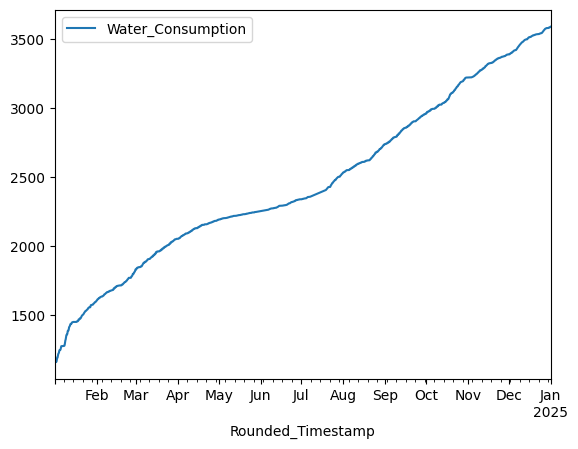

In [2]:
"""
water_usage=pd.read_csv('Water Usage/SOC Outlet-1/Table.csv',usecols=["Date","Time","Device Name","water_flow_in_cubic_meter"],parse_dates=["Date"],index_col="Date")
data=water_usage[::-1]
data.reset_index(inplace=True)
data.head(20)
"""
# Load dataset
water_usage = pd.read_csv('Water Usage/SOC Outlet-1/Table(1).csv',
                          usecols=["Date", "Time", "Device Name", "water_flow_in_cubic_meter"])

# Reverse order if needed
data = water_usage[::-1]

# Set index and ensure DateTime format
data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"],format="%d/%m/%Y %H:%M:%S")
data["Rounded_Timestamp"] = data["Timestamp"].dt.round("6H")
#data = data.drop_duplicates(subset=["Rounded_Timestamp"], keep="first")  # Keep first occurrence
# Set the new Timestamp as index
data.set_index("Rounded_Timestamp", inplace=True)

# Drop the original "Date" and "Time" columns if no longer needed
data.drop(columns=["Date", "Time","Timestamp","Device Name"], inplace=True)


# Ensure daily frequency
data = data.resample("6H").mean() 

# Rename column
data.rename(columns={'water_flow_in_cubic_meter': 'Water_Consumption'}, inplace=True)
print(data.isna().sum())
data.interpolate(method="linear", inplace=True)
# Display first 20 rows
print(data.head(20))
data.plot()

In [15]:

# Normalize the water consumption data
scaler = MinMaxScaler(feature_range=(0, 1))
data["Water_Consumption"] = scaler.fit_transform(data[["Water_Consumption"]])
original_timestamps = data.index  # Save timestamps before preprocessing

# Converts data into sequences for LSTM
def create_sequences(data, time_steps=10):
    """ Create input-output pairs for LSTM training. """
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])  # Use past 'time_steps' values as input
        y.append(data[i + time_steps])      # Predict the next value
    X, y = np.array(X), np.array(y)

    # Ensure 3D shape: (samples, time_steps, features=1)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y

# Define time steps (e.g., past 10 readings)
time_steps = 5
data_values=data["Water_Consumption"].values
X, y = create_sequences(data_values, time_steps)

# Print shape (should be 3D: samples, time_steps, features)
print("X shape:", X.shape)  # (num_samples, time_steps, 1)
print("y shape:", y.shape)  # (num_samples,)




X shape: (1459, 5, 1)
y shape: (1459,)


In [16]:
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_valid = scaler.transform(y_valid.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)


# Verify final shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (1167, 5, 1), y_train shape: (1167,)
X_test shape: (146, 5, 1), y_test shape: (146,)


In [17]:
def build_lstm_model(optimizer):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(10, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [18]:
optimizers = {
    "Adam": Adam(learning_rate=0.001),
    "SGD": SGD(learning_rate=0.01, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.001),
    "Adagrad": Adagrad(learning_rate=0.01),
    "Adadelta": Adadelta(learning_rate=1.0)
}

In [19]:
import matplotlib.pyplot as plt

def plot_training_loss(history, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training Loss')
    plt.legend()
    plt.show()

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Predict on test data
def pred(model, X_test, y_test, scaler, original_timestamps):
    predictions = model.predict(X_test)
    
    # Reverse scaling
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    predicted_timestamps = original_timestamps[-len(predictions):]  # Match predictions with time
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    print(f"Test RMSE: {rmse:.2f}")
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(predicted_timestamps,y_test_actual, label="Actual Water Demand")
    plt.plot(predicted_timestamps,predictions, label="Predicted Water Demand", linestyle="dashed")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Water Consumption")
    plt.title("LSTM Water Demand Forecasting")
    plt.show()


Training LSTM with Adam optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.3126 - val_loss: 0.1194
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0439 - val_loss: 0.0036
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - val_loss: 5.8626e-04
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3400e-04 - val_loss: 1.0715e-04
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.5692e-05 - val_loss: 6.6856e-05
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4781e-05 - val_loss: 4.3885e-05
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7294e-05 - val_loss: 3.3690e-05
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7355e-05 - val_loss: 2.6294e-05
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8730e-05 - val_loss: 2.0399e-05
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2941e-05 - val_loss: 1.6859e-05
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0829e-05 - val_loss: 1.4312e-05
Epoch 

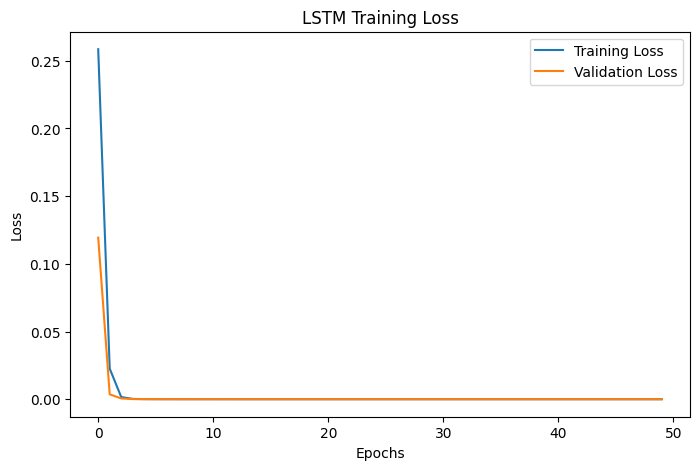

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Test RMSE: 0.00


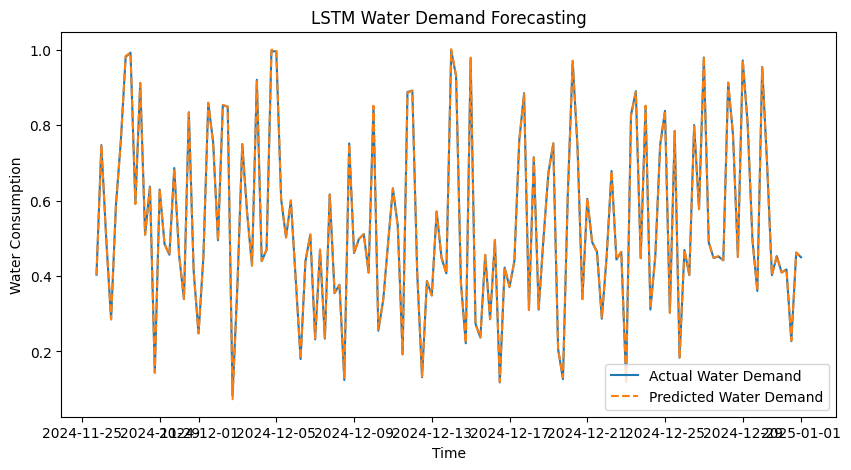


Training LSTM with SGD optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1744 - val_loss: 0.0668
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0549 - val_loss: 0.0573
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0517 - val_loss: 0.0505
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0426 - val_loss: 0.0427
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0343 - val_loss: 0.0303
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0228 - val_loss: 0.0143
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100 - val_loss: 0.0039
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 5.0232e-04
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2480e-04 - val_loss: 4.8930e-05
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4835e-05 - val_loss: 2.4844e-05
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1590e-05 - val_loss: 2.1511e-05
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms

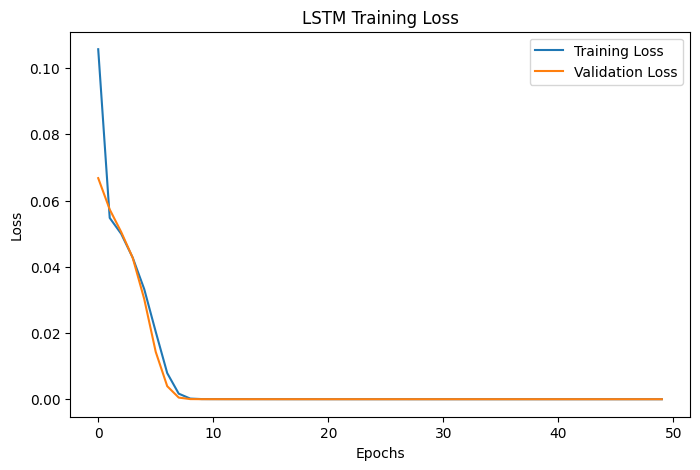

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Test RMSE: 0.00


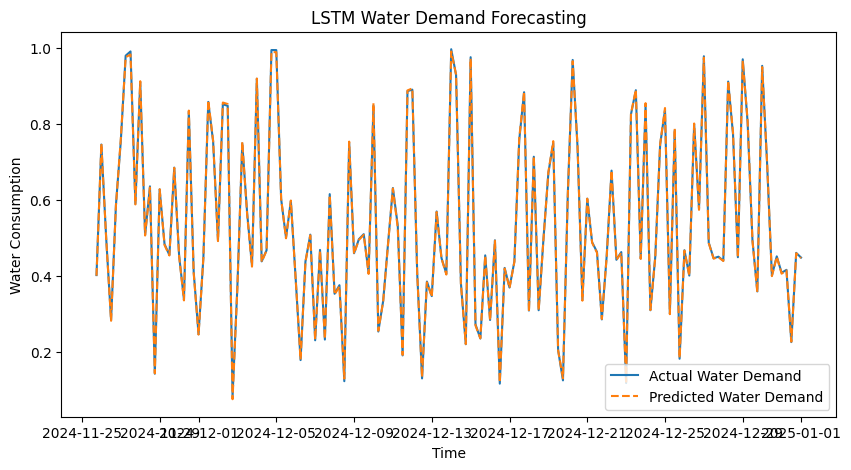


Training LSTM with RMSprop optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.2462 - val_loss: 0.0107
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 5.3317e-04
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6588e-04 - val_loss: 5.5481e-04
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7248e-04 - val_loss: 7.9118e-04
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7599e-04 - val_loss: 4.0436e-04
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5651e-04 - val_loss: 0.0010
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1080e-04 - val_loss: 9.3040e-04
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5910e-04 - val_loss: 8.7753e-04
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7921e-04 - val_loss: 9.2525e-04
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0222e-04 - val_loss: 7.4317e-04
Epoch 12/5

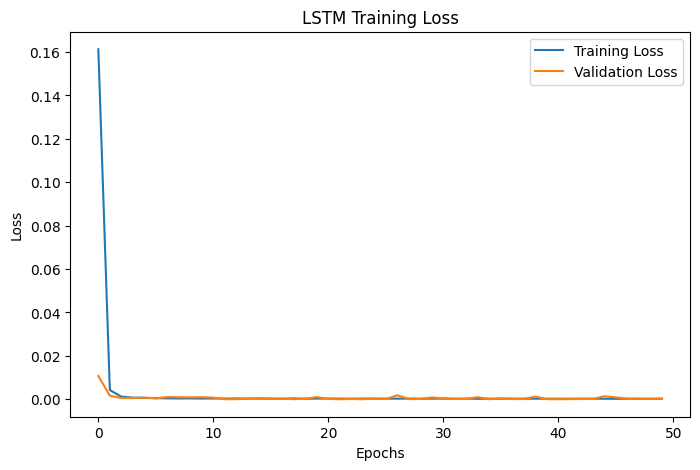

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Test RMSE: 0.02


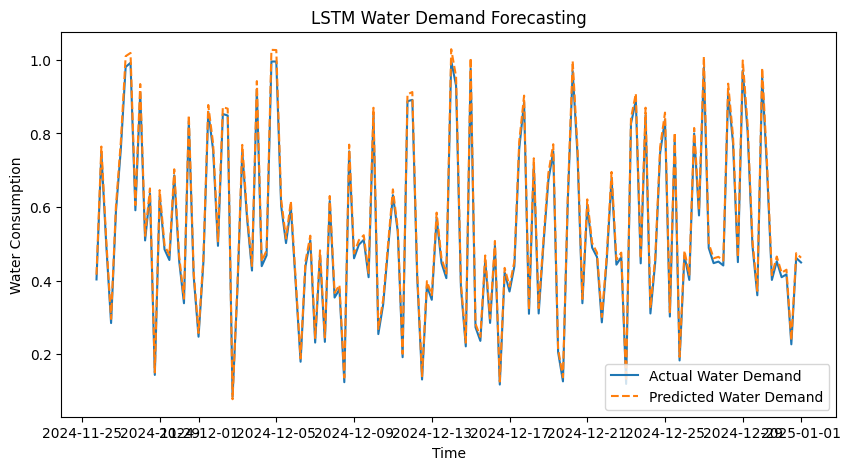


Training LSTM with Adagrad optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.2193 - val_loss: 0.0912
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0650 - val_loss: 0.0518
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0433 - val_loss: 0.0448
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0404 - val_loss: 0.0414
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0353 - val_loss: 0.0372
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0343 - val_loss: 0.0341
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0306 - val_loss: 0.0304
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0272 - val_loss: 0.0268
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0229 - val_loss: 0.0235
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0212 - val_loss: 0.0197
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0180 - val_loss: 0.0164
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - val_l

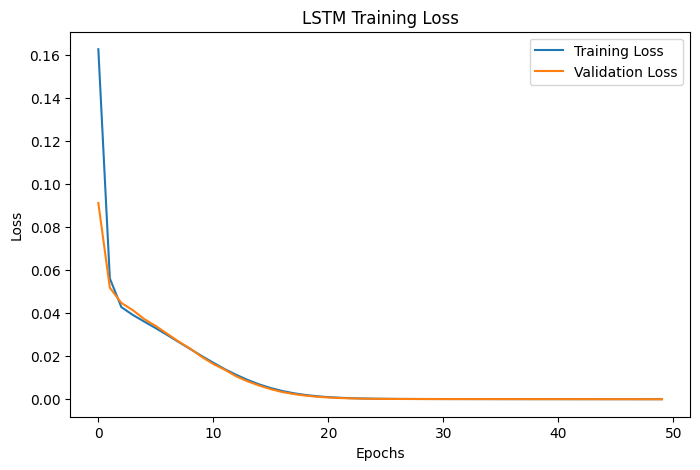

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Test RMSE: 0.01


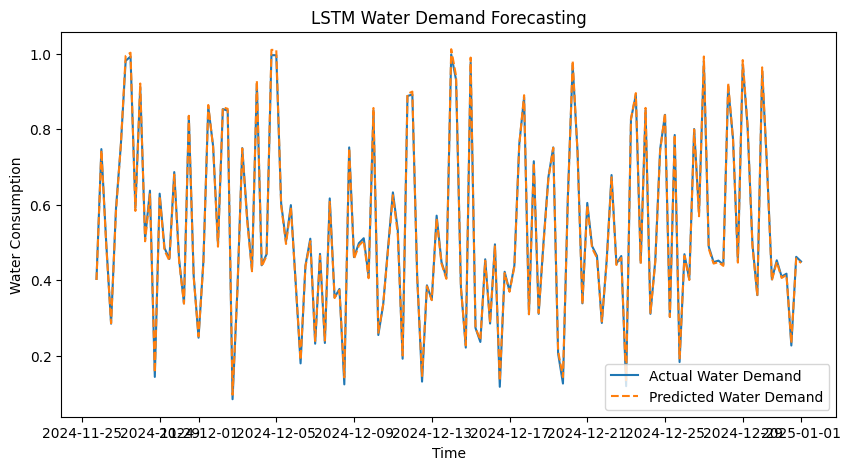


Training LSTM with Adadelta optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.2677 - val_loss: 0.0175
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - val_loss: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3434e-04 - val_loss: 1.3772e-04
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1738e-04 - val_loss: 6.5059e-05
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0885e-04 - val_loss: 3.6844e-04
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0237e-04 - val_loss: 5.0869e-04
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.8002e-04 - val_loss: 1.8379e-04
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1263e-04 - val_loss: 6.3586e-04
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3230e-04 - val_loss: 3.9558e-04
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1843e-04 - val_loss: 4.2221e-04
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8092e-04 - val_loss: 1.1458e-04
Ep

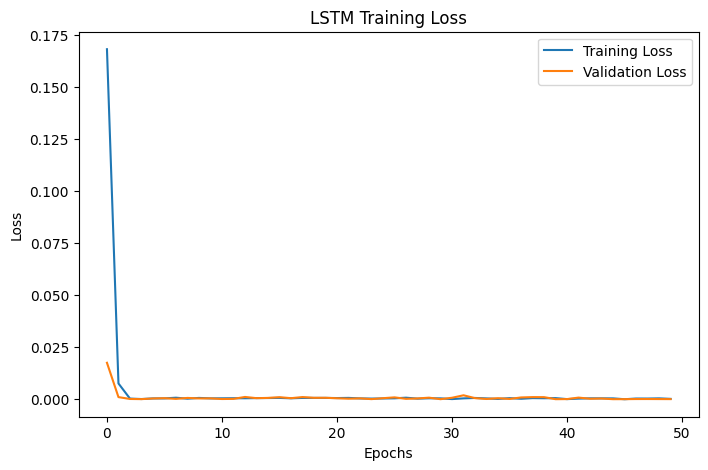

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
Test RMSE: 0.01


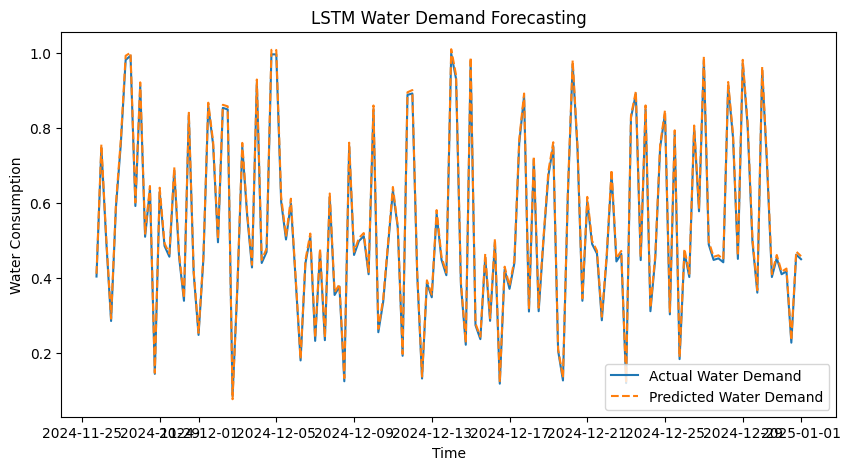

In [21]:
for name, opt in optimizers.items():
    print(f"\nTraining LSTM with {name} optimizer...")
    lstm_model = build_lstm_model(opt)
    history_lstm = lstm_model.fit(X_train, y_train, 
                              epochs=50, 
                              batch_size=32, 
                              validation_data=(X_valid, y_valid), 
                              verbose=1)
    # Plot for LSTM
    plot_training_loss(history_lstm, "LSTM")
    pred(lstm_model,X_test,y_test,scaler,original_timestamps)


Training LSTM with Adam optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.2792 - val_loss: 0.0906
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0910 - val_loss: 0.0902
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0808 - val_loss: 0.0897
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0861 - val_loss: 0.0901
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0785 - val_loss: 0.0909
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0805 - val_loss: 0.0899
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0805 - val_loss: 0.0902
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0824 - val_loss: 0.0891
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0820 - val_loss: 0.0898
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0813 - val_loss: 0.0891
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0810 - val_loss: 0.0889
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0813 - val_l

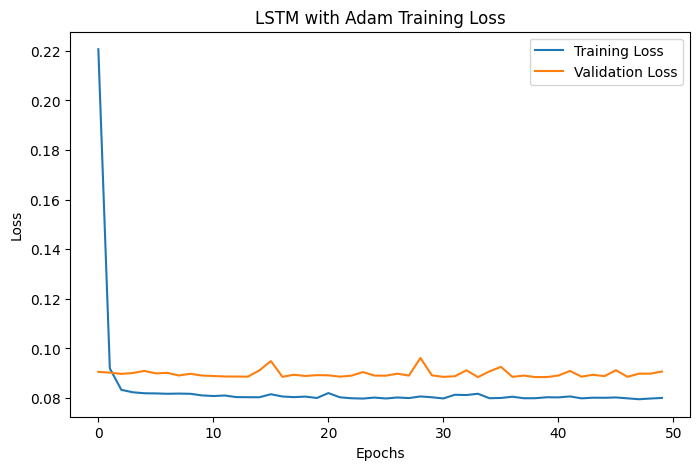

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
Test RMSE: 0.29


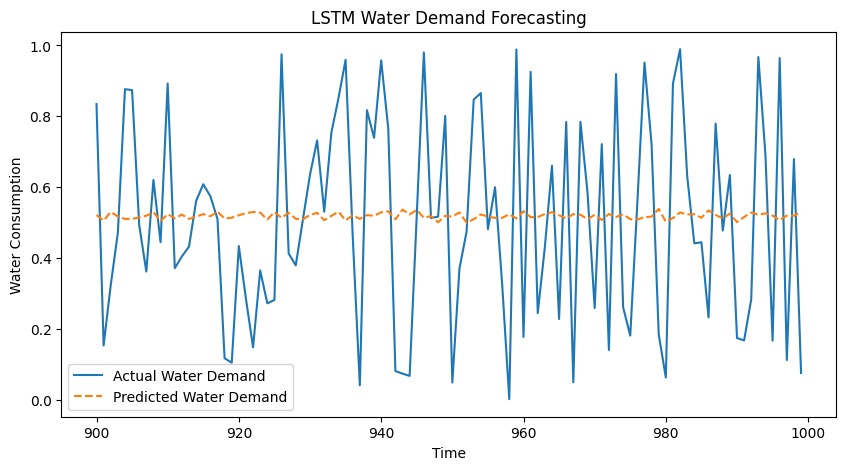


Training LSTM with SGD optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.1935 - val_loss: 0.0903
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0893 - val_loss: 0.0907
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0780 - val_loss: 0.0886
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0785 - val_loss: 0.0887
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0842 - val_loss: 0.0885
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0796 - val_loss: 0.0887
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0776 - val_loss: 0.0895
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0849 - val_loss: 0.0884
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0832 - val_loss: 0.0889
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0818 - val_loss: 0.0887
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0798 - val_loss: 0.0907
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0820 - val_l

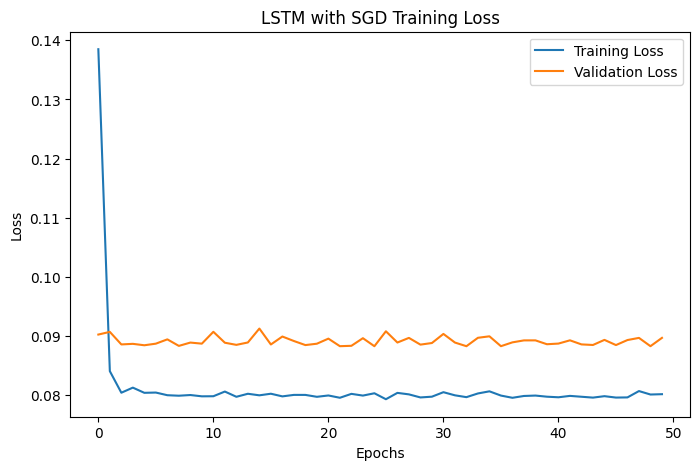

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
Test RMSE: 0.29


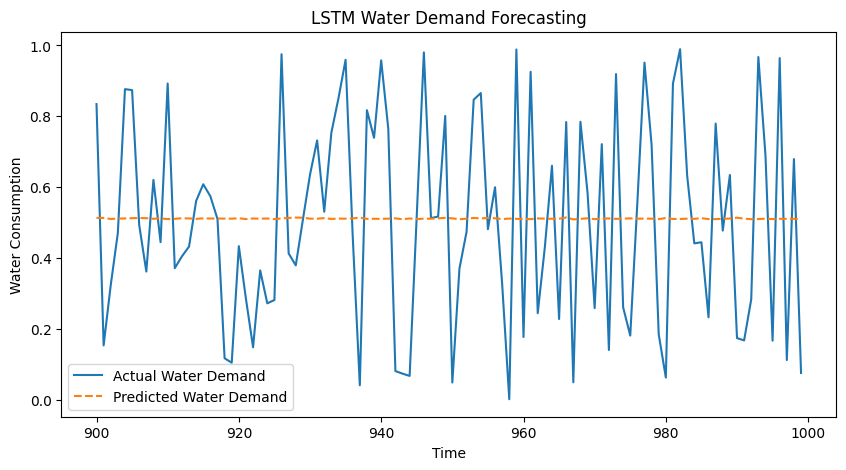


Training LSTM with RMSprop optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.2277 - val_loss: 0.0899
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0880 - val_loss: 0.0896
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0844 - val_loss: 0.0894
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0822 - val_loss: 0.1009
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0847 - val_loss: 0.0889
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0798 - val_loss: 0.0900
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0858 - val_loss: 0.0984
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0755 - val_loss: 0.0887
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0851 - val_loss: 0.0887
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0797 - val_loss: 0.0900
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0782 - val_loss: 0.0933
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0809 - val_l

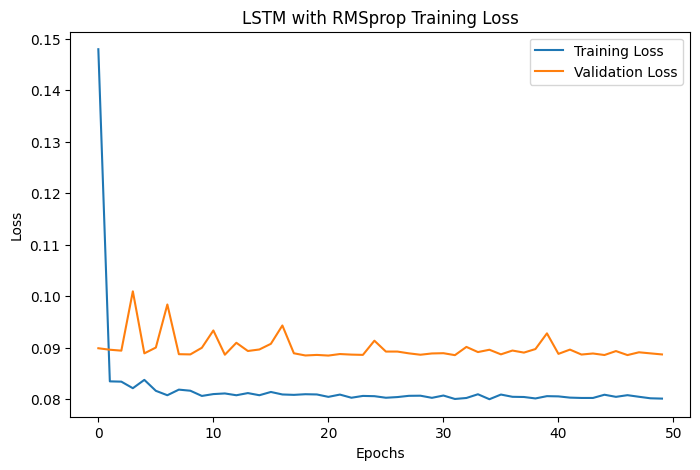

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
Test RMSE: 0.29


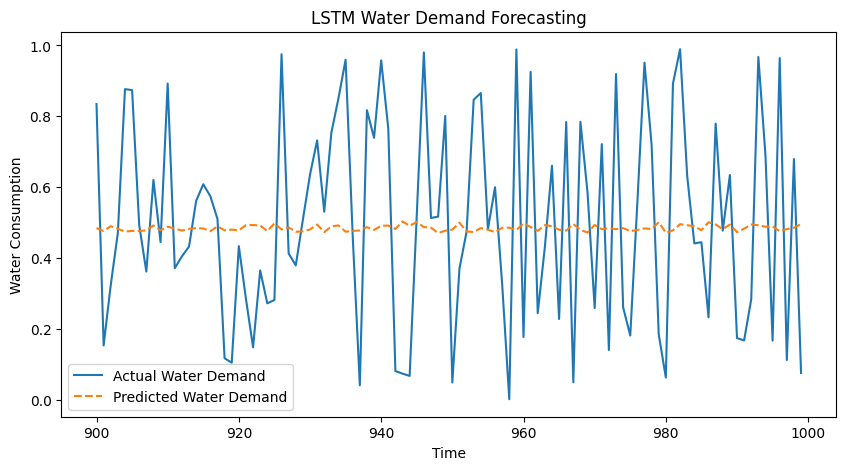


Training LSTM with Adagrad optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.2272 - val_loss: 0.1024
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0931 - val_loss: 0.0884
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0825 - val_loss: 0.0888
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0788 - val_loss: 0.0890
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0793 - val_loss: 0.0889
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0841 - val_loss: 0.0889
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0809 - val_loss: 0.0888
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0829 - val_loss: 0.0886
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0775 - val_loss: 0.0888
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0806 - val_loss: 0.0888
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0759 - val_loss: 0.0885
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0782 - val_l

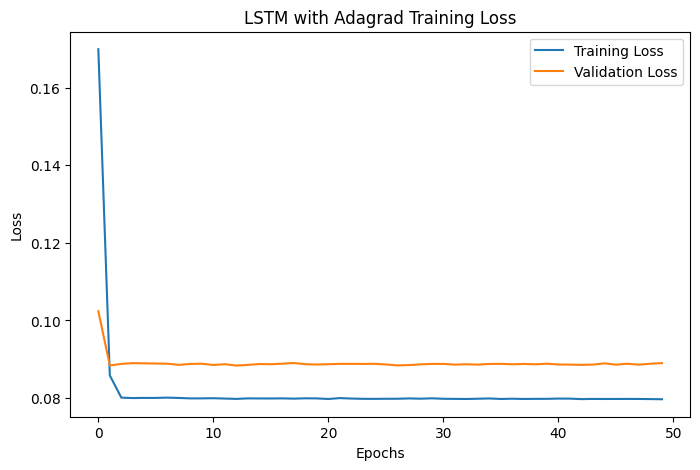

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
Test RMSE: 0.29


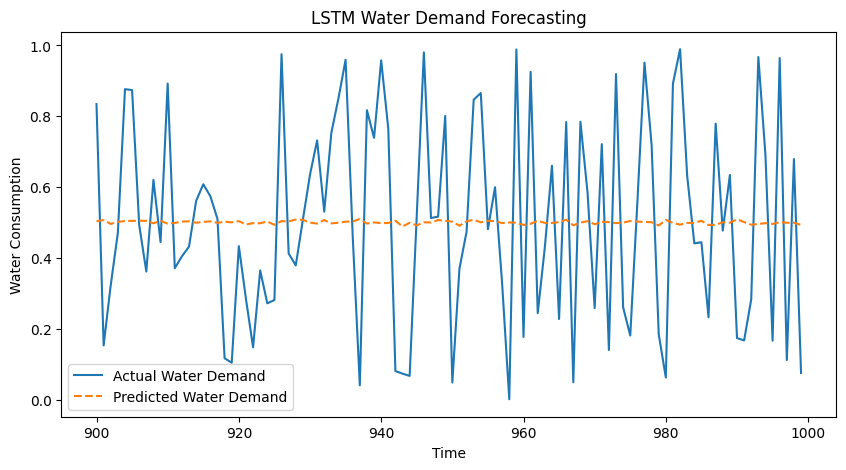


Training LSTM with Adadelta optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.2043 - val_loss: 0.0903
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0860 - val_loss: 0.0926
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0811 - val_loss: 0.0894
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0812 - val_loss: 0.0892
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0843 - val_loss: 0.0890
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0835 - val_loss: 0.0912
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0822 - val_loss: 0.0887
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0813 - val_loss: 0.0888
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0811 - val_loss: 0.0897
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0830 - val_loss: 0.0887
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0847 - val_loss: 0.0885
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0797 - val_l

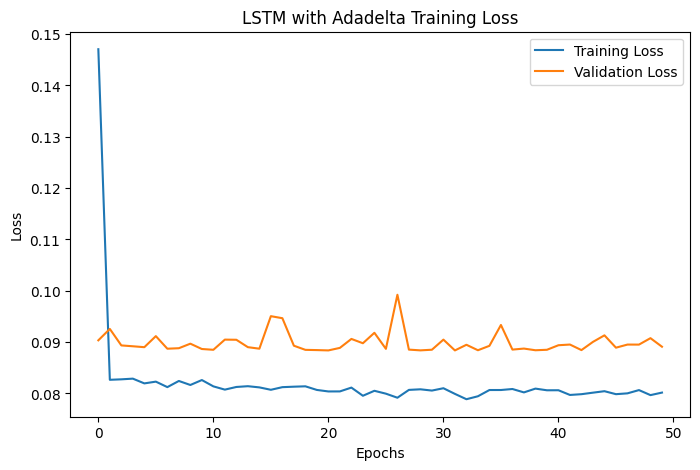

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
Test RMSE: 0.29


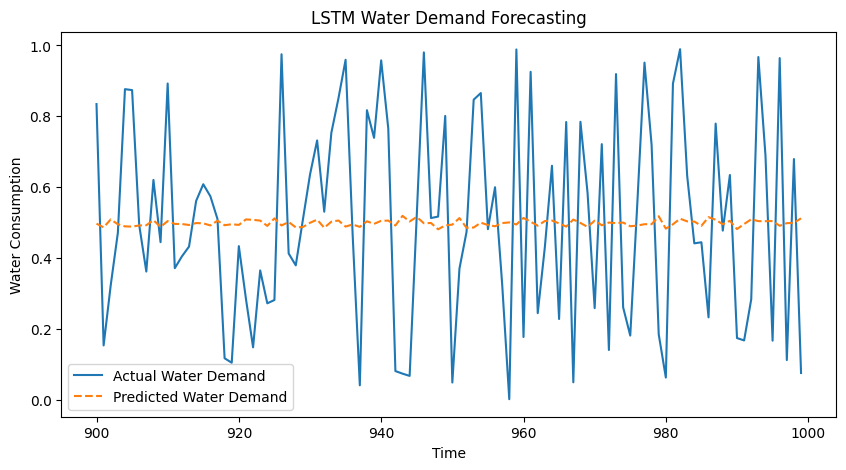

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Sample Data
timesteps = 1000
features = 1
X = np.random.rand(timesteps, 10, features)
y = np.random.rand(timesteps, 1)

# Splitting into train, validation, and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

# Scaling Data
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train)
y_valid = scaler.transform(y_valid)
y_test = scaler.transform(y_test)

# Define Optimizers
optimizers = {
    "Adam": Adam(learning_rate=0.001),
    "SGD": SGD(learning_rate=0.01, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.001),
    "Adagrad": Adagrad(learning_rate=0.01),
    "Adadelta": Adadelta(learning_rate=1.0)
}

# Function to Build LSTM Model
def build_lstm_model(optimizer):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(10, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Function to Plot Training Loss
def plot_training_loss(history, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training Loss')
    plt.legend()
    plt.show()

# Function for Prediction & Evaluation
def pred(model, X_test, y_test, scaler, original_timestamps):
    predictions = model.predict(X_test)
    
    # Reverse Scaling
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    print(f"Test RMSE: {rmse:.2f}")
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(original_timestamps[-len(y_test_actual):], y_test_actual, label="Actual Water Demand")
    plt.plot(original_timestamps[-len(predictions):], predictions, label="Predicted Water Demand", linestyle="dashed")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Water Consumption")
    plt.title("LSTM Water Demand Forecasting")
    plt.show()

# Generate timestamps (assuming original data has timestamps)
original_timestamps = np.arange(len(y))  # Replace with actual timestamps

# Train Models with Different Optimizers
for name, opt in optimizers.items():
    print(f"\nTraining LSTM with {name} optimizer...")
    lstm_model = build_lstm_model(opt)
    history_lstm = lstm_model.fit(X_train, y_train, 
                                  epochs=50, 
                                  batch_size=32, 
                                  validation_data=(X_valid, y_valid), 
                                  verbose=1)

    # Plot for LSTM
    plot_training_loss(history_lstm, f"LSTM with {name}")

    # Prediction and Evaluation
    pred(lstm_model, X_test, y_test, scaler, original_timestamps)
